In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import pyjet
import time

from matching import matching

plt.style.use("scientific.mplstyle")

file = uproot.open("/eos/user/c/clange/PFNano/myNanoProdMc_NANO.root")
event_tree = file['Events']

In [2]:
max_idx = 500

pts = event_tree['PF_pt'].array(entry_stop=max_idx, library='np')
etas = event_tree['PF_eta'].array(entry_stop=max_idx, library='np')
phis = event_tree['PF_phi'].array(entry_stop=max_idx, library='np')
masses = event_tree['PF_mass'].array(entry_stop=max_idx, library='np')
puppi_weights = event_tree['PF_puppiWeight'].array(entry_stop=max_idx, library='np')

recojet_pts = event_tree['Jet_pt'].array(entry_stop=max_idx, library='np')
recojet_etas = event_tree['Jet_eta'].array(entry_stop=max_idx, library='np')
recojet_phis = event_tree['Jet_phi'].array(entry_stop=max_idx, library='np')
recojet_nconst = event_tree['Jet_nConstituents'].array(entry_stop=max_idx, library='np')

In [3]:
def manual_jet_clustering(pts, etas, phis, masses, puppi_weights, myjetR):
    '''Cluster jets for one event with anti kt, 15 Gev pt cut off, and using puppi pileup mitigation and only considering particles with non zero weight.'''
    
    event_4vect = np.column_stack((pts*puppi_weights , etas, phis, masses)).astype('float64')
    event = np.core.records.fromarrays(event_4vect.transpose(), dtype=pyjet.DTYPE_PTEPM)
    
    # only consider particles with non zero puppi weight
    physical_mask = np.where(puppi_weights!=0.0, True, False)
    reduced_event = event[physical_mask]

    sequence = pyjet.cluster(reduced_event, R=myjetR, p=-1)
    my_jets = sequence.inclusive_jets(ptmin=15)
    
    return my_jets


def myjets_recojets_differences(myjetR):
    '''Find differences in position, pt and # constituents for myjet and recojet, using R=myjetR in manual clustering.'''
    delta_Rs = [] # sparation of jet cores
    delta_pts = [] # Normalized difference in pt: (mypt-recopt)/recopt
    delta_ns = [] # difference in number of constituents
    
    for i in range(max_idx):
        myjets = manual_jet_clustering(pts[i], etas[i], phis[i], masses[i], puppi_weights[i], myjetR)
        myjets_etas, myjets_phis = [myjet.eta for myjet in myjets], [myjet.phi for myjet in myjets] 
        my_matching = matching(myjets_etas, myjets_phis, recojet_etas[i], recojet_phis[i])
        
        # find distance for every made match in the currently considered event i
        for j, reco_idx in enumerate(my_matching):
            if reco_idx == -1:
                continue
            else:
                delta_eta = myjets[j].eta - recojet_etas[i][reco_idx]
                delta_phi = myjets[j].phi - recojet_phis[i][reco_idx] 
                delta_Rs.append(np.sqrt(delta_eta**2 + delta_phi**2))

                delta_pts.append((myjets[j].pt - recojet_pts[i][reco_idx])/recojet_pts[i][reco_idx])

#                 delta_n = len(myjets[j].constituents()) - recojet_nconst[i][reco_idx]
#                 delta_ns.append(delta_n)
                
                
    return delta_Rs, delta_pts, delta_ns

In [9]:
n_jetR = 5
n_jetRs = np.linspace(0.35, 0.45, n_jetR)

delta_Rs, delta_pts, delta_ns = [], [], []

for jetR in n_jetRs:
    t1 = time.time()
    R, pt, n = myjets_recojets_differences(jetR)
    t2 = time.time()
    print("Clustering with R={} completed in {:.2f} sec".format(jetR, t2-t1))
    delta_Rs.append(R)
    delta_pts.append(pt)
    #delta_ns.append(n)

Clustering with R=0.35 completed in 0.48 sec
Clustering with R=0.375 completed in 0.39 sec
Clustering with R=0.4 completed in 0.40 sec
Clustering with R=0.425 completed in 0.40 sec
Clustering with R=0.45 completed in 0.39 sec


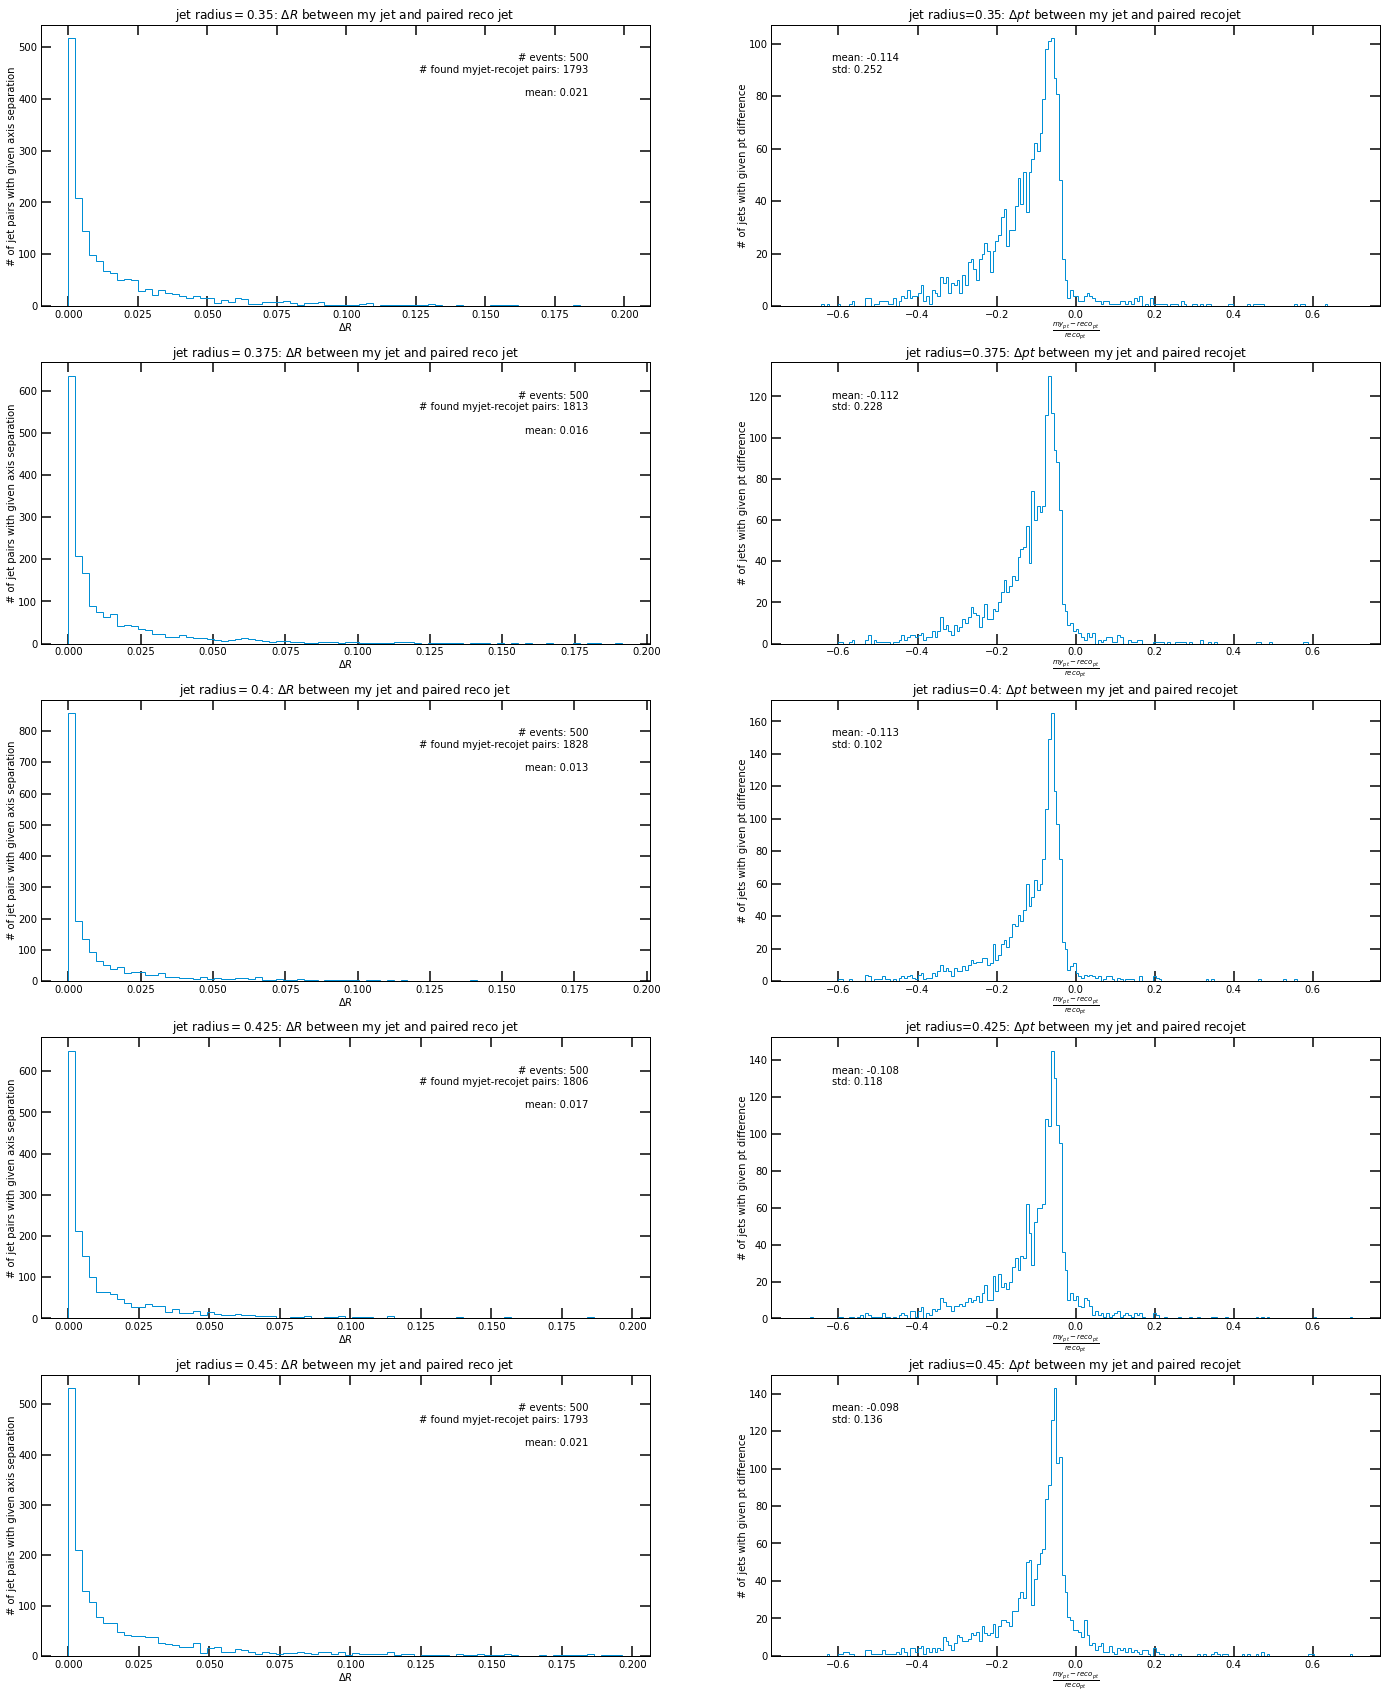

In [14]:
fig, axs = plt.subplots(n_jetR, 2, figsize=(24,6*n_jetR))

for i, ax in enumerate(axs):
    content, _ , _ = ax[0].hist(delta_Rs[i], bins=80, histtype='step') 
    stats_str = "# events: {}\n# found myjet-recojet pairs: {:.0f}\n\nmean: {:.3f}".format(max_idx, np.sum(content), np.mean(delta_Rs[i]))
    ax[0].text(0.9, 0.9, stats_str, ha='right', va='top', transform = ax[0].transAxes)
    ax[0].set_title("jet radius$={}$: $\Delta R$ between my jet and paired reco jet".format(n_jetRs[i]))
    ax[0].set_xlabel("$\Delta R$")
    ax[0].set_ylabel("# of jet pairs with given axis separation")

    _, bins_pts, _ = ax[1].hist(delta_pts[i], bins=200, range=(-0.7, 0.7), histtype='step')
    stats_str = "mean: {:.3f}\nstd: {:.3f}".format(np.mean(delta_pts[i]), np.std(delta_pts[i]))
    ax[1].text(0.1, 0.9, stats_str, ha='left', va='top', transform = ax[1].transAxes)
    ax[1].set_title("jet radius={}: $\Delta pt$ between my jet and paired recojet".format(n_jetRs[i]))
    ax[1].set_xlabel("$\\frac{my_{pt}-reco_{pt}}{reco_{pt}}$")
    ax[1].set_ylabel("# of jets with given pt difference")

    
plt.show()

fig.savefig("plots/range_jetR.pdf")  

#### Conclusion
$R=0.4$ gives best fit, as expected.